In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import collections
from collections import Counter
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# The Ising model in 2D
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours. 

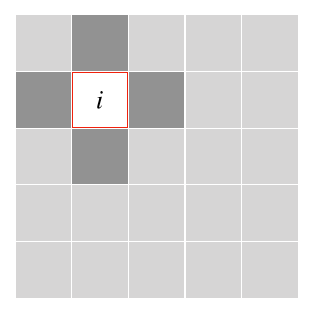 


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours. 

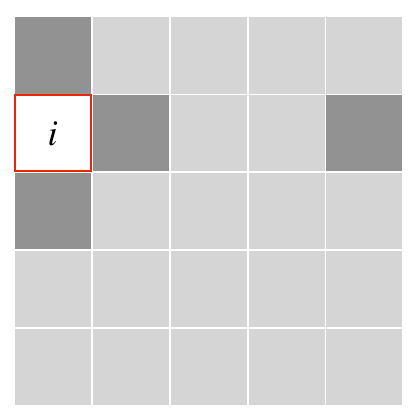 


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. 

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [2]:
def create_initial_config(N=None):
    """
    Create the starting initial configuration.
    
    All elements are {-1, 1} with 50% prob.
    The lattice is a square of size N.
    
    Parameters
    ----------
    N : int
        The system size.

    Returns
    -------
    config : np.array, (N, N)
        A random {-1, 1} array of size (N, N).
    """
    config=np.random.randint(0,2,size=(N,N))*2-1
    return config    

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [3]:
config = create_initial_config(N=100)

In [4]:
print(config)

[[-1 -1 -1 ...  1 -1 -1]
 [-1 -1 -1 ...  1 -1  1]
 [-1 -1  1 ...  1  1  1]
 ...
 [-1 -1  1 ... -1 -1  1]
 [ 1  1 -1 ... -1 -1 -1]
 [ 1 -1 -1 ...  1 -1 -1]]


To plot our system we can use `plt.imshow()`, as follows:

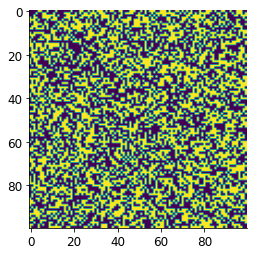

In [5]:
plt.imshow(config);

### Exercise 4.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

$\Delta E = 2 s_{i,j}\sum_{n=1}^4 {Js_n} = 2 s_{i,j} \sum_{n=1}^4 {s_n}$. That is the sum over the spin of the neighbors times 2 times the spin before the change of spin.

### Exercise 4.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [7]:
def metropolis_single_update(config=None, T=None):
    ##K_b=1.380649*10**-23, K_b=1
    '''
    Do a single Monte Carlo update using Metropolis algorithm.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The current configuration.
    T : float
        The temperature.

    '''
    # make sure config is square
    N, M = config.shape
    assert N==M
    
    # choose random site
    i = np.random.randint(0,M)
    j = np.random.randint(0,N)
    s =  config[i, j]
        
    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 2*s*( config[(i-1)%N, j]+ config[(i+1)%N, j]+ config[i, (j-1)%N]+ config[i, (j+1)%N])
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE < 0:
        # flip the spin
        s *= -1
        # set effective DeltaE to DeltaE 
        effDeltaE = DeltaE
        
    # case DeltaE >= 0
    else:
        # flip the spin with certain probability
        x=np.random.uniform()
        if x<np.exp(-DeltaE/T):
            # flip the spin
            s *= -1
            # set effective Delta E 
            effDeltaE = DeltaE
        
    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s
    
    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size. 

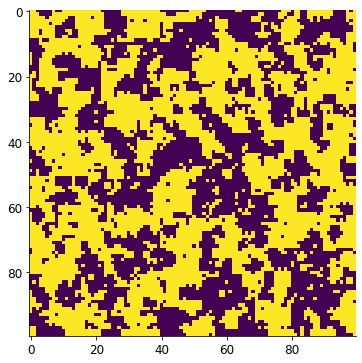

In [7]:
T_c = 2/np.log(1+np.sqrt(2))

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,6))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)

for t in range(100000):
    # update the system
    DeltaE = metropolis_single_update(config, T=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

As we can notice, with temperature at $T_c$, the "thermal agitation" will cause some flip of the spins, with the consequence that there will not form big clusters.

### Exercice 4.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [8]:
def get_energy(config):
    """
    Compute the energy of a configuration.
    
    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.
        
    Returns
    -------
    E : float
        The energy of the configuration.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    horizontal_edges = [
        (i, j, i, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    
    return E#/N**2

In [9]:
def get_energy_evolution(N, T, n_updates):
    """
    Compute the energy evolution of a 2D Ising instance.
    
    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.
        
    Returns
    -------
    Es : np.array, (n_updates, )
    """
    Es=np.zeros(shape=(n_updates), dtype=int)
    config=create_initial_config(N)
    Es[0]=get_energy(config)
    # update the system
    for i in range (1, n_updates):
        Es[i]=Es[i-1]+metropolis_single_update(config, T=T_c)
    
    return Es

### Exercise 4.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [24]:
energy_evolution = get_energy_evolution(N=50, T=T_c, n_updates=10**6)

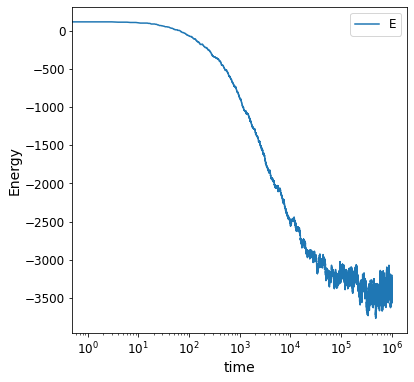

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.semilogx(energy_evolution)

ax.set_xlabel("time")
ax.set_ylabel("Energy")
ax.legend("Energy")

### Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

We can distinguish two different period, the first correspond to the loss of energy by the system, that will find out the way to loose as much energy as possible in order to be in equilibrium. After a certain period (~$10^3-10^4$ flip) the casual flips of the spin will cause local gain of energy: so the global energy will fluctuate.

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [10]:
import sys
sys.path.append("../code/")
from ising_sethna import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [11]:
# create an instance of IsingModel
ising = IsingModel(N=100)

In [12]:
# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

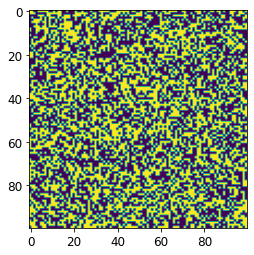

In [13]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [16]:
ising.SweepMetropolis(nTimes=100)

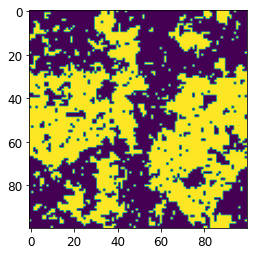

In [17]:
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [11]:
#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

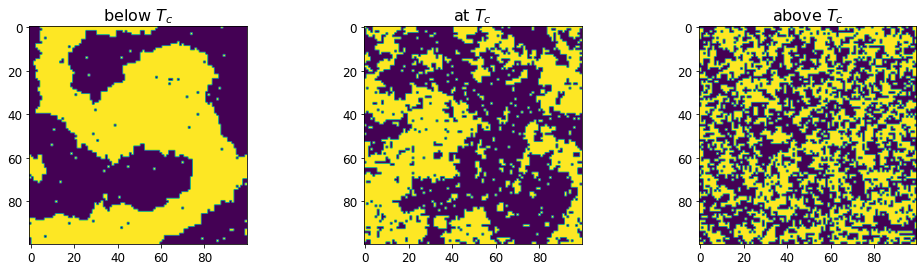

In [12]:
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Exercice 4.7
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute.

To do a fair comparison, remember to take into account what "one update" means for each case.

In [21]:
%%timeit
# your Ising implementation running for some number of updates
for t in range(10000):
    DeltaE = metropolis_single_update(config, T=T_c)

212 ms ± 7.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
# Sethan's implementation running for some **equivalent** number of updates
ising.SweepMetropolis(nTimes=1)

77.9 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We notice that, in this case, config is a lattice of 100 x 100 cells, so we need $100^2$ single updates. Sethna's implementation perform $N^2$ flip each time, so we need only one call of the function, for every value of N. The second algorithm is much faster than the first, for N=100, 78 ms vs 212 ms, that is one order of magnitude smaller, and the advantage of time will rise as we rise N.

## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise 4.8
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

In [34]:
# set system size, temperature
ising = IsingModel(N=100, T=T_c)
t=100
Es=np.zeros(t)
# run some Wolff sweeps, check if equilibrium 
# update the system
for i in range (0,t):
        Es[i]=get_energy(ising.lattice*2-1)
        ising.SweepWolff()  

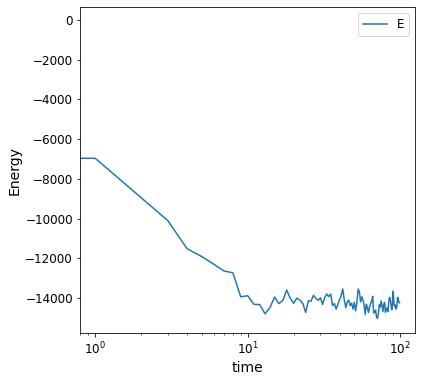

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(Es, label="E")
ax.set_xlabel("time")
ax.set_ylabel("Energy")
ax.legend("Energy")

From the graph we can see that after $\sim 10 - 20$ sweeps the value of the energy starts to fluctuate around the energy of equilibrium, so 10-20 sweeps are sufficient in order to be in equilibrium

### Exercise 4.9
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [14]:
def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # instantiate model
    ising = IsingModel(N=system_size, T=temperature)
    # equilibrate
    ising.SweepWolff(nTimes=equilibration_time) 
    config=(ising.lattice*2)-1
    # compute magnetization
    m=abs(np.sum(config))
    return m/system_size**2

### Exercise 4.10
+ Compute the magnetization for a system of size $N=64$, for different values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [38]:
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=50)
# system size
system_size = 64
# equilibration time
equilibration_time = 20

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = calculate_magnetization(system_size, temperature, equilibration_time)
    magnetizations.append(magnetization)

Text(0, 0.5, '|M|')

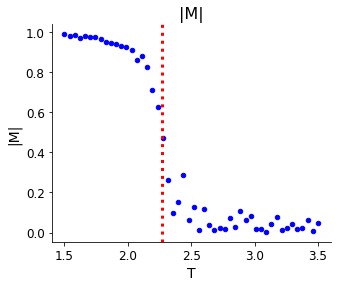

In [39]:
# define critical temperature
T_c = 2/np.log(1+np.sqrt(2))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures, magnetizations,
    # style keywords
    edgecolors="blue", color="blue", s=20
)
ax.axvline(
    T_c,
    # style keywords
    c="red", lw=3, ls=':'
)
ax.set_title("|M|")
ax.set_xlabel("T")
ax.set_ylabel("|M|")

As T is near to $T_c$ the magnetization drop instantly to zero and start to oscillate around that value. We have plotted the absolut value of the density of magnetization (normalized) because we are interested in the global orientations of the spins. That grap show us the distintion of the two phase, the ferromagnetic one, with $T<T_c$, and the paramagnetic one, with $T>T_c$

## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

$\chi = \frac{\partial \langle M \rangle}{\partial H} = ... = \frac {1}{T}\left\langle (M - \langle M \rangle)^2 \right\rangle$ with analogue calculus for specific heat, and $k_B=1$. 

### Exercise 4.12
Write a function that computes the energy of an Ising configuration.

As usually, you can use the **template** below if it helps you, or if you prefer you can also write **your own function** from scratch.

In [15]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    config = ising.lattice*2-1
    N = len(config)
    
    horizontal_edges = [
        (i, j, i, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    return E/N**2

### Exercise 4.13
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [16]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temeperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    # initiate model
    ising =  IsingModel(N=system_size, T=temperature)
    # thermalize
    ising.SweepWolff(nTimes=equilibration_time)  
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for _ in range(n_samples):
        # change from 0,1 to -1,1 notation
        config=ising.lattice*2-1
        # get magnetization
        m=abs(np.sum(config))
        ms.append(m)
        m2s.append(m**2)
        # get energy
        e=compute_energy(ising)
        es.append(e)
        e2s.append(e**2)
        # update system
        ising.SweepWolff() 
    
    # compute susceptibility and specific heat
    T=temperature
    susceptibility = (1/T)*(np.mean(m2s)-np.mean(ms)**2)
    specific_heat = (1/T**2)*(np.mean(e2s)-np.mean(es)**2)
    
    return susceptibility, specific_heat

### Exercise 4.14
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [44]:
# define range of temperatures: 50 points from 1.5 to 3.5.
temperatures = np.linspace(1.5, 3.5, num=50)
# system size
system_size = 30
# equilibration time
equilibration_time = 20
# n_samples
n_samples = 100

# loop over temperatures, compute susceptibility and specific_heat
c = []
chi = []
for temperature in temperatures:
    a,b = calculate_susceptibility_specific_heat(system_size, temperature, equilibration_time, n_samples)
    chi.append(a)
    c.append(b)

Text(0.5, 1.0, 'Specific heat')

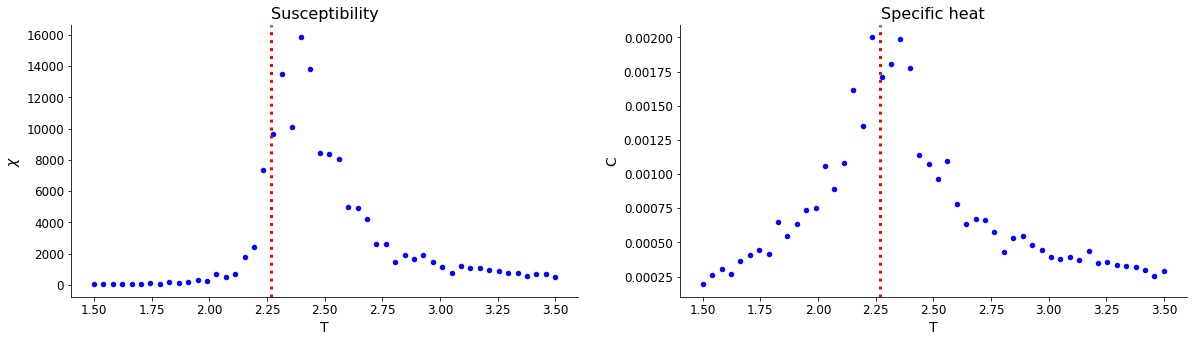

In [80]:
T_c = 2/np.log(1+np.sqrt(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax=ax1
ax.scatter(temperatures, chi, edgecolors="blue", color="blue", s=20)
ax.axvline(T_c, c="red", lw=3, ls=':')
ax.set_ylabel("$\chi$")
ax.set_xlabel("T")
ax.set_title("Susceptibility")

ax=ax2
ax.scatter(temperatures, c, edgecolors="blue", color="blue", s=20)
ax.axvline(T_c, c="red", lw=3, ls=':')
ax.set_ylabel("C")
ax.set_xlabel("T")
ax.set_title("Specific heat")

### Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

The result proof the existence of a phase transition in proximity of $T_c$, in fact, for the specific heat we have a maximum in proximity of $T=T_c$ beacause the phase transition need some energy to be done, that energy that does not contribute to heat the system, so the specific heat is bigger in corrispondence of the phase transition. Also the susceptibility shows a phase transition: it is the derivative of the magnetization, and the magnetization is really correlated with tha phase of the system, so when the magnetization drop down has an inflection points with vertical tangent, that means an higher value of the derivative (suseptibility). The teorical prediction are very well correlated to sperimental results.

# Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

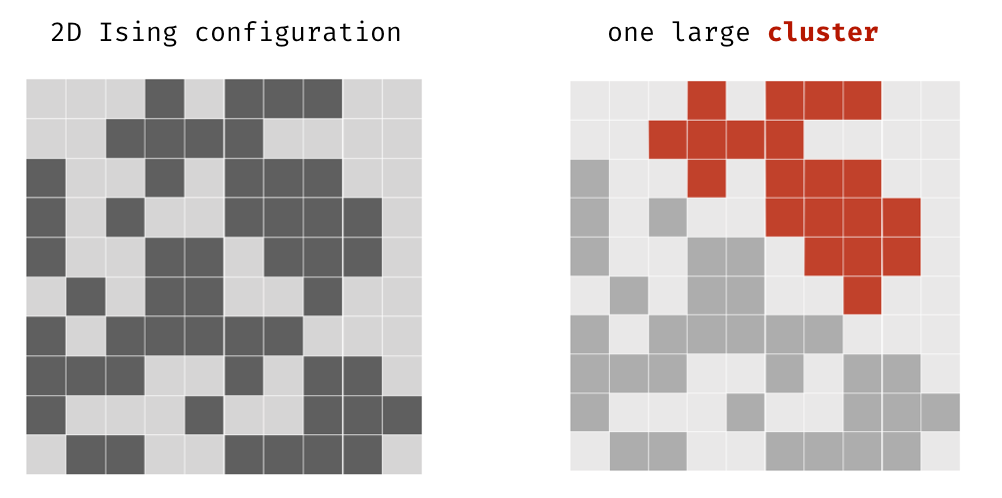

### Exercise 4.16
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

Two algorithm has been made:

1)the recusive way: this method uses the "vicini" function, that, given a site in the matrix, check if the neighbors have already been check in some cluster and if not, and if they are in the same cluster of the first site, put them in the same cluster and return back the neighbors site that are put in the cluster. 
Than the function go ahead and check all the sites of the matrix

This method is too slow so I choose to think about another method:

2)row and column (get_labels): that firstly chech every row and make horizontal cluster (with periodic boundaty condition), than check every column and put in the same cluster the previus cluster that share the same spin and are near.

The secondo way was faster, so I chose to use that methos.

### Exercise 4.17
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.

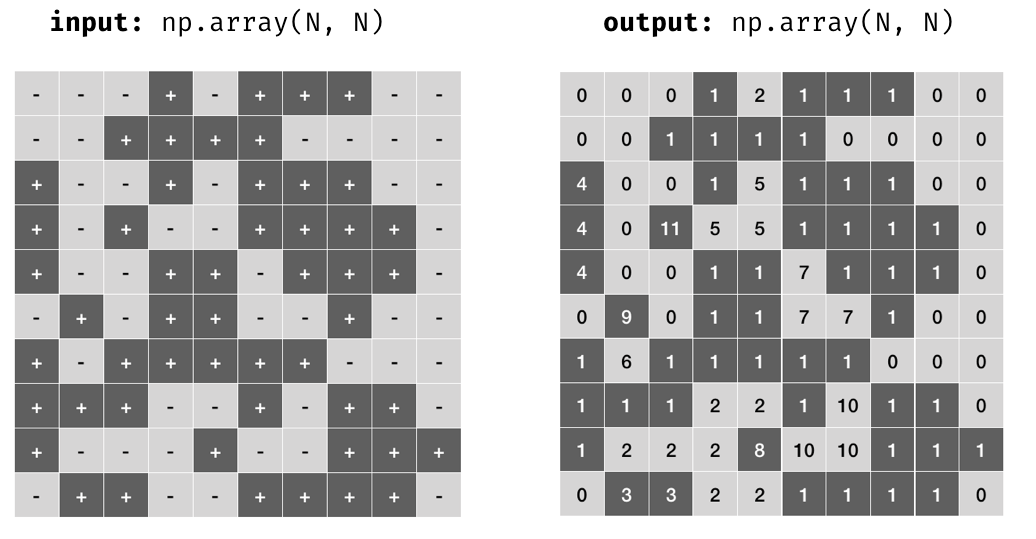

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [17]:
def vicini(config, labels, siti, s, x):
    i=s[0]
    j=s[1]
    N=len(config)
    d=[-1,+1]
    neighbours = []
    if s not in siti:
        labels[i, j]=x
    for k in d:
        if config[(i+k)%N, j]==config[i,j] and [(i+k)%N, j] not in siti: 
            labels[(i+k)%N, j]=x
            neighbours.append([(i+k)%N,j])
            #print(labels)
        if config[i,(j+k)%N]==config[i,j] and [i, (j+k)%N] not in siti: 
            labels[i, (j+k)%N]=x
            neighbours.append([i,(j+k)%N])
    return neighbours


In [18]:
def get_labels_recursive(config):
    """
    Get unique cluster labels.
    
    Parameters
    ----------
    config : np.array, (N, N)
        Configuration of the system in {-1, 1} notation
    Returns
    -------
    labels : np.array, (N, N)
        Labels that identify the clusters
    """
    N, M = config.shape
    labels = np.zeros (shape=(N,M))
    x=1
    siti= []
    while len(siti)<len(config)**2:
        a = np.random.randint(0,M)
        b = np.random.randint(0,N)
        s=[a,b]
        siti.extend(vicini(config, labels, siti, s , x))
        if s not in siti:
            siti.append(s)
        for m,n in siti:
                siti.extend(vicini(config, labels, siti, [m,n] , x))
        x+=1
    return labels

In [19]:
def get_labels(config):
    N, M = config.shape
    assert N==M
    labels = np.zeros (shape=(N,M))
    x=1
    #clusters orizzontali
    for i in range(0,N):
        labels[i,0]=x
        for j in range(1,N):
            if config[i,j]==config[i,j-1]:
                labels[i,j]=x
            else: 
                x+=1
                labels[i,j]=x
        x+=1
        if config[i,-1]==config[i,0]:
                labels[labels == labels[i,-1]] = labels[i,0]
    #clusters verticali
    for j in range(0,N):
        for i in range(0,N):
            if config[i,j]==config[(i+1)%N,j]:
                labels[labels == labels[i,j]] = labels[(i+1)%N,j]
    return labels

### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [20]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])

In [21]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])

In [22]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])


Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

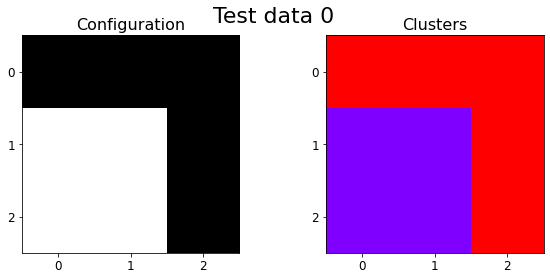

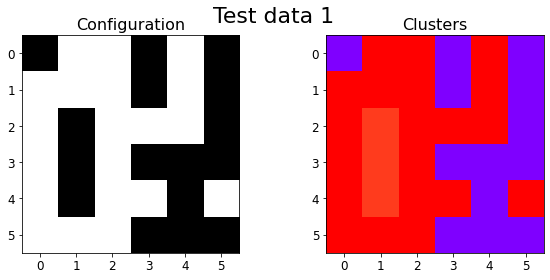

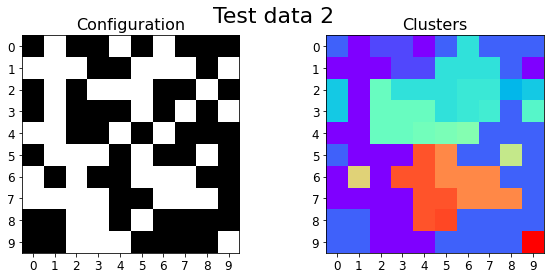

In [23]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = get_labels(config)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)

If your function doesn't work, you might want to use this cell to inspect your results

<AxesSubplot:>

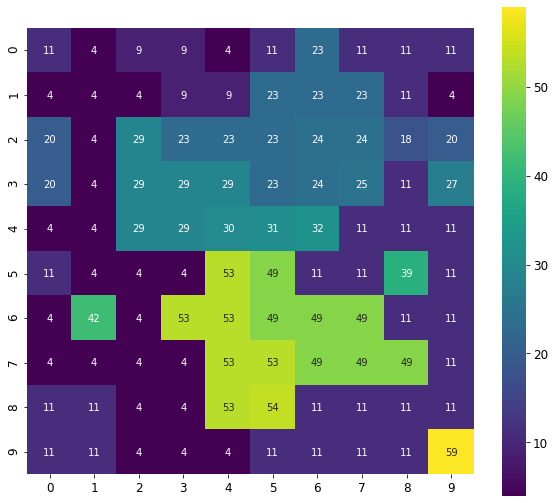

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

[[-1  1  1 ...  1  1  1]
 [-1 -1  1 ... -1 -1 -1]
 [ 1  1  1 ... -1 -1  1]
 ...
 [ 1  1 -1 ...  1  1 -1]
 [ 1 -1  1 ... -1  1 -1]
 [-1  1 -1 ... -1  1 -1]]
Wall time: 27.2 s


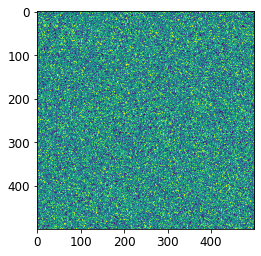

In [25]:
%%time
inizio = create_initial_config(N=500)
print(inizio)
plt.imshow(inizio)
labels = get_labels(inizio)

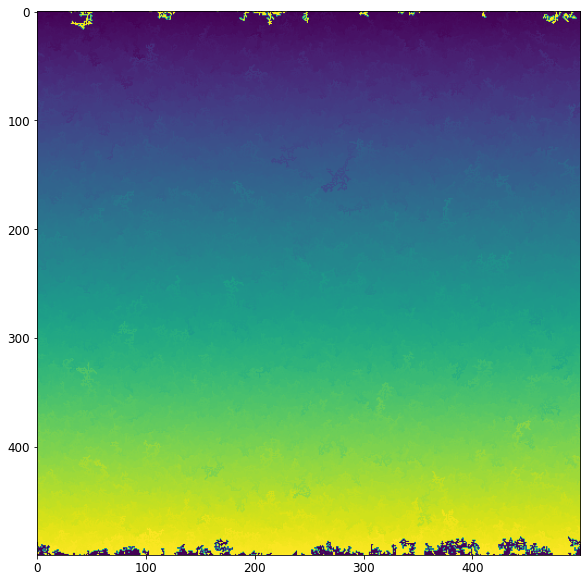

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(labels)

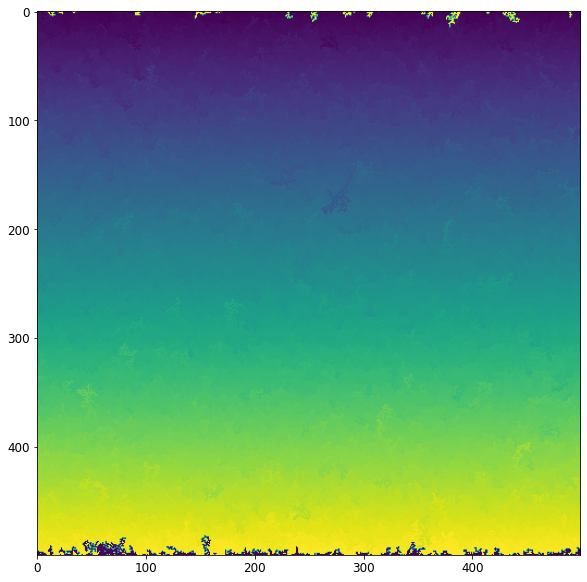

In [30]:
T_c = 2/np.log(1+np.sqrt(2))
ising = IsingModel(N=500, T=T_c)
config = ising.lattice*2-1
labels = get_labels(config)
plt.figure(figsize=(10, 10))
plt.imshow(labels)

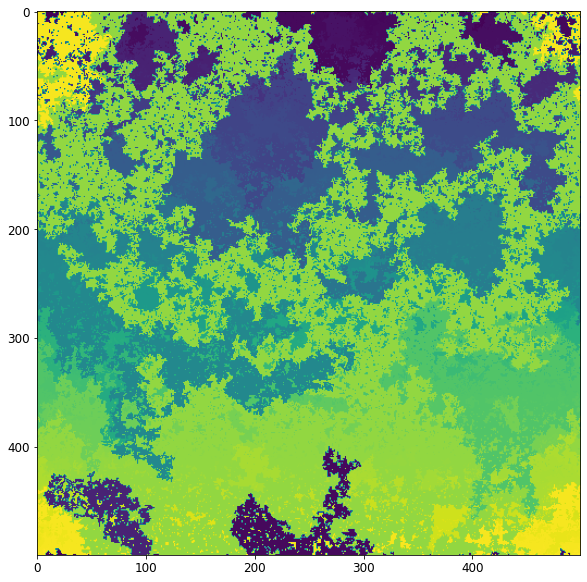

In [31]:
ising.SweepWolff(nTimes=5) 
config = ising.lattice*2-1
labels = get_labels(config)
plt.figure(figsize=(10, 10))
plt.imshow(labels)

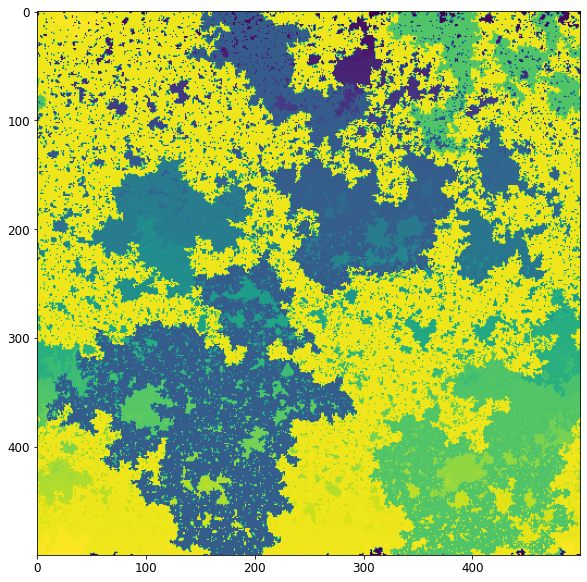

In [32]:
ising.SweepWolff(nTimes=5) 
config = ising.lattice*2-1
labels = get_labels(config)
plt.figure(figsize=(10, 10))
plt.imshow(labels)

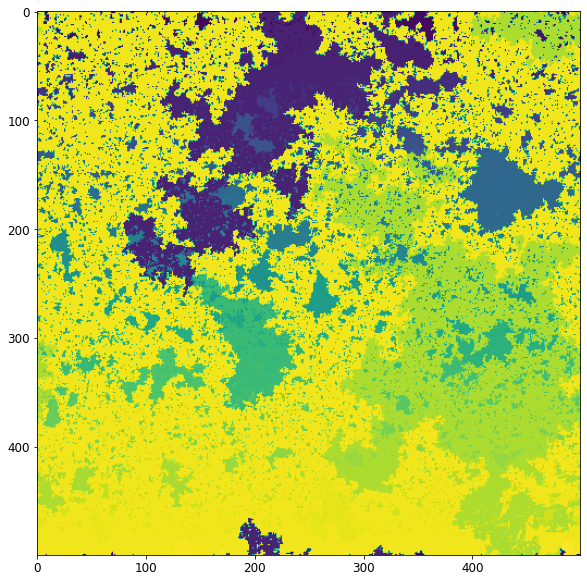

In [33]:
ising.SweepWolff(nTimes=5) 
config = ising.lattice*2-1
labels = get_labels(config)
plt.figure(figsize=(10, 10))
plt.imshow(labels)

### Exercise 4.18
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [20]:
def get_sizes(labels):
    a = np.reshape(labels, len(labels)**2)
    b = Counter(a)
    c = sorted(b)
    sizes = []
    for i in range (0,len(c)):
        sizes.append(b[c[i]])
    return np.sort(sizes)

### Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

The spins are uncorrelated, so we can expect that will form clusters of every size, with a decreasing scaling, in particular there will be not correlations between big clusters and small clusters, so we can finda clusters of every dimension.



### Exercice 4.20
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

In [47]:
ising = IsingModel(N=200, T=100)
ising.SweepWolff(nTimes=20)  
config = ising.lattice*2-1
labels = get_labels(config)
sizes = get_sizes(labels)

Text(0.5, 1.0, 'Plot of theory scaling ($x^{-2}$ ) compared with numeric scaling')

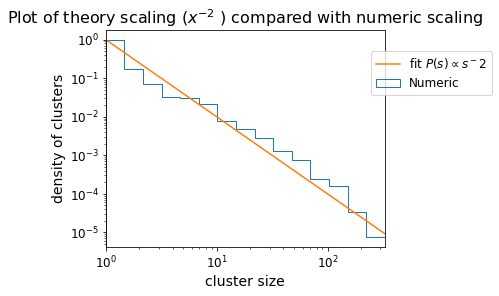

In [48]:
# use logarithmic bins and logarithmic axes!
bins = np.geomspace(min(sizes), max(sizes), num=16)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, density="true", histtype="step", label="Numeric")
ax.plot(bins, bins**-2, label= r"fit $P(s) \propto s^-2$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("cluster size")
ax.set_ylabel("density of clusters")
ax.set_xlim(min(sizes), max(sizes))

ax.legend(loc=(0.95, 0.7), frameon=True)
ax.set_title(r"Plot of theory scaling ($x^{-2}$ ) compared with numeric scaling")



The previsions are respected from the plot, maybe seems that the theoretical scaling exponent -2 is a little smaller than the effective power law, a best approximation could be -1.9, anyway it isn't very far from the expected -2. However we can see that tha maximum size of the clusters is in the order of $10^2$, that is smaller than the case of $T=T_C$

### Exercise 4.21

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

In [50]:
# do simulation
T_c = 2/np.log(1+np.sqrt(2))
ising = IsingModel(N=200, T=T_c)
ising.SweepWolff(nTimes=30)  
config = ising.lattice*2-1
labels = get_labels(config)
sizes = get_sizes(labels)

Text(0.5, 1.0, 'Plot of theory scaling ($x^{-2}$ ) compared with numeric scaling')

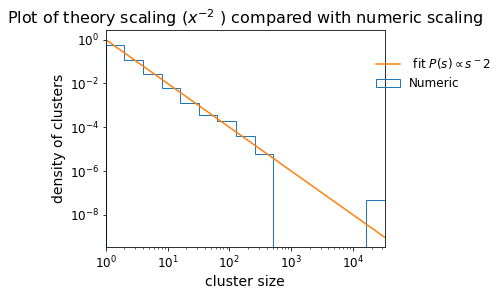

In [51]:
# plot results
bins = np.geomspace(min(sizes), max(sizes), num=16)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, density="true", histtype="step", label = "Numeric")
ax.plot(bins, bins**-2, label = r" fit $P(s) \propto s^-2$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("cluster size")
ax.set_ylabel("density of clusters")
ax.set_xlim(min(sizes), max(sizes))

ax.legend(loc=(0.95, 0.7), frameon=False)
ax.set_title(r"Plot of theory scaling ($x^{-2}$ ) compared with numeric scaling")

In this case the number of large cluster distribution is bigger than high temperature case, this because the temperature is smaller than before, and at $T=T_c$ there will be bigger cluster.